In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import RandomRotation, RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import applications
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [4]:
# Menentukan BATCH_SIZE dan IMG_SIZE
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

# Menentukan SEED dan menggunakan set_seed untuk mengatur seed
SEED = 0
tf.random.set_seed(SEED)

# Mendefinisikan directory dataset
directory = '/kaggle/input/wayang-bagong-cepot-gareng-petruk-semar/images/images/train'
val_directory = '/kaggle/input/wayang-bagong-cepot-gareng-petruk-semar/images/images/val'

# Membuat train_dataset menggunakan image_dataset_from_directory
train_dataset = image_dataset_from_directory(directory=directory,
                                             label_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=SEED)

# Membuat full_validation_dataset menggunakan image_dataset_from_directory
full_validation_dataset = image_dataset_from_directory(directory=directory,
                                                       label_mode='categorical',
                                                       batch_size=BATCH_SIZE,
                                                       image_size=IMG_SIZE,
                                                       shuffle=True,
                                                       validation_split=0.2,
                                                       subset='validation',
                                                       seed=SEED)

Found 1350 files belonging to 5 classes.
Using 1080 files for training.
Found 1350 files belonging to 5 classes.
Using 270 files for validation.


In [5]:
# Menghitung jumlah batch pada full_validation_dataset
validation_batches = len(full_validation_dataset)
print(f'Total number of full_validation_dataset batches : {validation_batches}')

# Membagi full_validation_dataset menjadi validation_dataset dan test_dataset
validation_dataset = full_validation_dataset.take(validation_batches // 2)
test_dataset = full_validation_dataset.skip(validation_batches // 2)

# Menampilkan jumlah batch pada validation_dataset dan test_dataset
print(f'Number of batches in validation dataset : {len(validation_dataset)}')
print(f'Number of batches in test dataset : {len(test_dataset)}')

Total number of full_validation_dataset batches : 9
Number of batches in validation dataset : 4
Number of batches in test dataset : 5


In [6]:
# Membuat variabel class_names
class_names = train_dataset.class_names

# Menampilkan class_names
class_names

['bagong', 'cepot', 'gareng', 'petruk', 'semar']

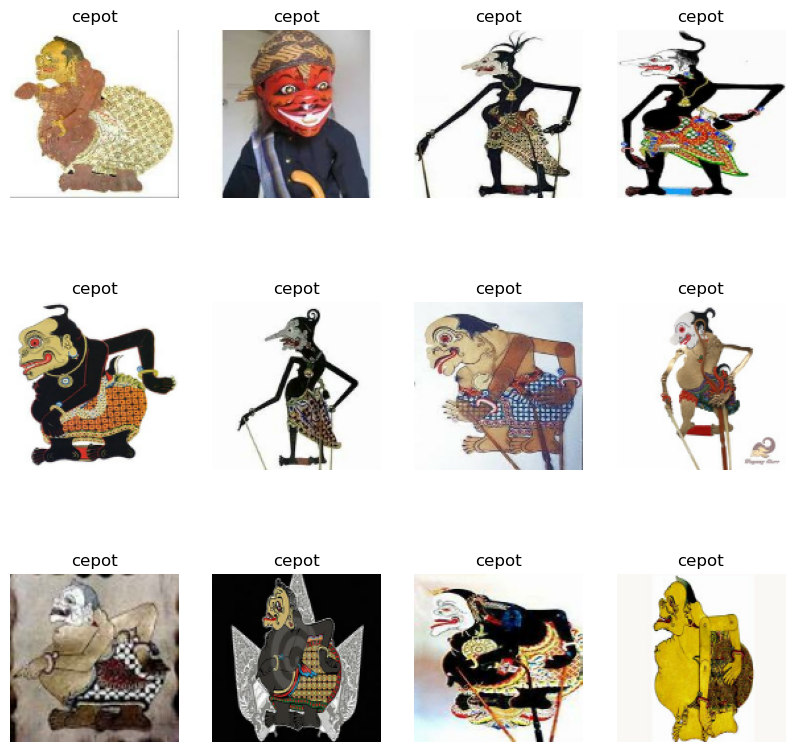

In [7]:
# Membuat plot gambar dari train_dataset
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[int(max(labels[i]))])
        plt.axis('off')

In [8]:
# Melakukan prefetch pada train_dataset
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
def data_augmentar():
    """This function applies two data augmentation techniques.
        First, augmentation with RandomRotation.
        Second, augmentation with RandomZoom
    """
    
    data_augmentation = Sequential()
    data_augmentation.add(RandomRotation(factor=(-0.15, 0.15)))
    data_augmentation.add(RandomZoom((-0.3, -0.1)))
    
    return data_augmentation

In [10]:
data_augmentation = data_augmentar()
assert(data_augmentation.layers[0].name.startswith('random_rotation'))
assert(data_augmentation.layers[0].factor == (-0.15, 0.15))
assert(data_augmentation.layers[1].name.startswith('random_zoom'))
assert(data_augmentation.layers[1].height_factor == (-0.3, -0.1))

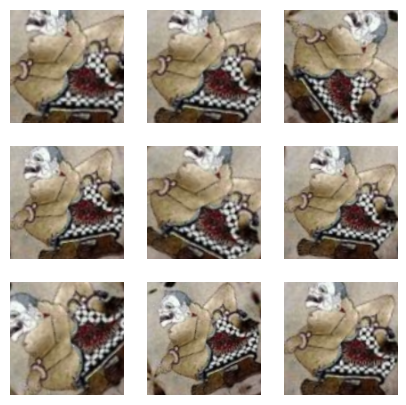

In [11]:
## applying data augmentation with a sample image.

plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
    image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(image)
        plt.imshow(augmented_image.numpy().astype('uint8'), cmap='gray')
        plt.axis('off')

In [12]:
preprocess_input = applications.efficientnet.preprocess_input

In [13]:
model = applications.EfficientNetB0(include_top=False)
len(model.layers)

16705208/16705208 [==============================] - 1s 0us/step


238

In [14]:
def alzheimer_classifier(image_shape=IMG_SIZE, data_augmentation=data_augmentar()):
    """This function creates a classifier for Alzheimer disease MRI images.
    
    Arguments:
        image_shape-> the size of the image in the form (height, width).
        data_augmentation-> the data augmentation object to apply on the training data.
        
    Returns:
        model-> the created classifier.
    """
    IMG_SHAPE = image_shape + (3,)
    base_model = applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                             include_top=False, 
                                             weights='imagenet')
    
    base_model.trainable = True
    for layer in base_model.layers[0:218]:
        layer.trainable = False
    
    inputs = Input(shape=IMG_SHAPE)
    x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(units=5, activation = "softmax")(x)
    
    model = Model(inputs, outputs)

    return model

In [15]:
alzheimer_model = alzheimer_classifier(IMG_SIZE, data_augmentation)

In [16]:
alzheimer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 1,357,365
Non-trainable params: 2,698,611
_________________________________________________________________


In [17]:
lr = 0.00001
alzheimer_model.compile(loss='categorical_crossentropy',
                        optimizer=Adam(learning_rate=lr),
                        metrics=['accuracy'])

In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
history = alzheimer_model.fit(train_dataset, 
                              validation_data = full_validation_dataset,
                              epochs = 15,
                              use_multiprocessing=True)

import joblib

Epoch 1/15
34/34 [==============================] - 25s 516ms/step - loss: 1.6834 - accuracy: 0.2491 - val_loss: 1.6082 - val_accuracy: 0.3185
Epoch 2/15
34/34 [==============================] - 15s 444ms/step - loss: 1.4540 - accuracy: 0.4000 - val_loss: 1.3873 - val_accuracy: 0.4259
Epoch 3/15
34/34 [==============================] - 15s 451ms/step - loss: 1.2903 - accuracy: 0.5213 - val_loss: 1.2009 - val_accuracy: 0.5630
Epoch 4/15
34/34 [==============================] - 15s 440ms/step - loss: 1.1276 - accuracy: 0.6426 - val_loss: 1.0505 - val_accuracy: 0.7333
Epoch 5/15
34/34 [==============================] - 15s 449ms/step - loss: 1.0127 - accuracy: 0.7380 - val_loss: 0.9250 - val_accuracy: 0.7889
Epoch 6/15
34/34 [==============================] - 15s 451ms/step - loss: 0.9096 - accuracy: 0.8019 - val_loss: 0.8215 - val_accuracy: 0.8852
Epoch 7/15
34/34 [==============================] - 19s 552ms/step - loss: 0.8127 - accuracy: 0.8611 - val_loss: 0.7352 - val_accuracy: 0.9000

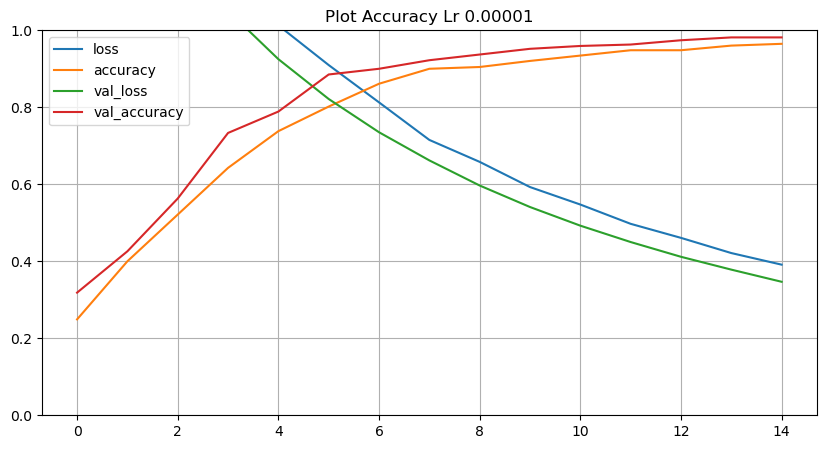

In [19]:
pd.DataFrame(history.history).plot(figsize=(10,5))
plt.grid(True)
plt.title('Plot Accuracy Lr 0.00001')
plt.gca().set_ylim(0,1)
plt.show()

Text(0.5, 1.0, 'Accuracy Evolution')

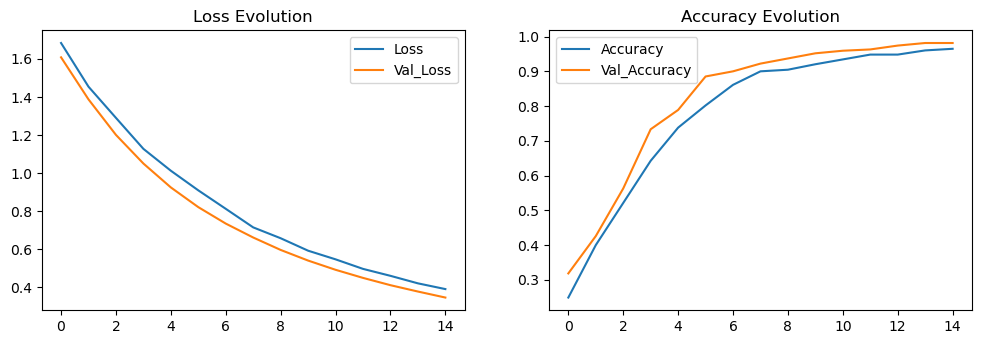

In [20]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2) 
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

#Data Train
y_true_train = []
y_pred_train = []

for x, y in train_dataset:
    # melakukan prediksi pada data latih
    predictions = alzheimer_model.predict(x)
    # mengubah nilai probabilitas menjadi label kelas
    y_pred_train.extend(np.argmax(predictions, axis=1))
    y_true_train.extend(np.argmax(y, axis=1))

# menghitung confusion matrix
cm = confusion_matrix(y_true_train, y_pred_train)
print("Confusion Matrix:")
print(cm)

# menghitung akurasi
acc = accuracy_score(y_true_train, y_pred_train)
print("Accuracy:", acc)

# menghitung precision
precision = precision_score(y_true_train, y_pred_train, average='macro')
print("Precision:", precision)

# menghitung recall
recall = recall_score(y_true_train, y_pred_train, average='macro')
print("Recall:", recall)

# menghitung F1-Score
f1 = f1_score(y_true_train, y_pred_train, average='macro')
print("F1-Score:", f1)

1/1 [==============================] - 1s 1s/step
Confusion Matrix:
[[207   0   0   0   5]
 [  0 227   0   0   0]
 [  3   0 203   3   0]
 [  0   0   0 218   0]
 [  6   1   1   0 206]]
Accuracy: 0.9824074074074074
Precision: 0.9823548129077599
Recall: 0.9820647565596474
F1-Score: 0.9821441633215642


In [22]:
#Data Test

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_true_test = []
y_pred_test = []

for x, y in test_dataset:
    # melakukan prediksi pada data uji
    predictions = alzheimer_model.predict(x)
    # mengubah nilai probabilitas menjadi label kelas
    y_pred_test.extend(np.argmax(predictions, axis=1))
    y_true_test.extend(np.argmax(y, axis=1))

# menghitung confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)
print("Confusion Matrix:")
print(cm)

# menghitung akurasi
acc = accuracy_score(y_true_test, y_pred_test)
print("Accuracy:", acc)

# menghitung precision
precision = precision_score(y_true_test, y_pred_test, average='macro')
print("Precision:", precision)

# menghitung recall
recall = recall_score(y_true_test, y_pred_test, average='macro')
print("Recall:", recall)

# menghitung F1-Score
f1 = f1_score(y_true_test, y_pred_test, average='macro')
print("F1-Score:", f1)

1/1 [==============================] - 0s 153ms/step
Confusion Matrix:
[[34  0  0  0  1]
 [ 0 26  0  0  0]
 [ 0  0 23  0  0]
 [ 0  0  0 27  0]
 [ 0  0  1  0 30]]
Accuracy: 0.9859154929577465
Precision: 0.9852150537634408
Recall: 0.9878341013824885
F1-Score: 0.9863945172232004


In [23]:
evaluation = alzheimer_model.evaluate(test_dataset)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

5/5 [==============================] - 2s 262ms/step - loss: 0.3467 - accuracy: 0.9930
Test Accuracy: 99.30%


In [27]:
model.save_weights('modelwayang.h5')

### Prediksi Wayang

In [30]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25859 sha256=06721d8e96be18723c4487985b39868d79c8bf56f8254e956a95a3405eb08584
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [70]:
import cv2
import imutils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)


def get_letters(img):
    letters = []    
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            roi = image[y:y + h, x:x + w]
            bordersize = int(0.1 * x)
            roi = cv2.copyMakeBorder(
                roi,
                top=bordersize,
                bottom=bordersize,
                left=bordersize,
                right=bordersize,
                borderType=cv2.BORDER_CONSTANT,
                value=[255, 255, 255]
            )
            thresh = cv2.resize(roi, (64, 64))
            img = np.array(thresh)
            img = np.expand_dims(img, axis=0)

            test_gen = ImageDataGenerator(
                rescale=1./255
            )
        
            image_gen = test_gen.flow(img)

            ypred = model.predict(image_gen)
            predicted_label = np.argmax(ypred, axis=1)
            letters.append(str(predicted_label))
        
            cv2.putText(img=roi, text=str(predicted_label), org=(0, int(roi.shape[1] * 0.1)),
                        fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 0, 0))
        plt.figure()
        plt.imshow(roi)
        
    return letters, image

def get_word(letter):
    word = "".join(letter)
    return word

1/1 [==============================] - 0s 42ms/step
predicted: [[[1 1 0 ... 1 1 0]
  [0 1 1 ... 0 1 1]]]


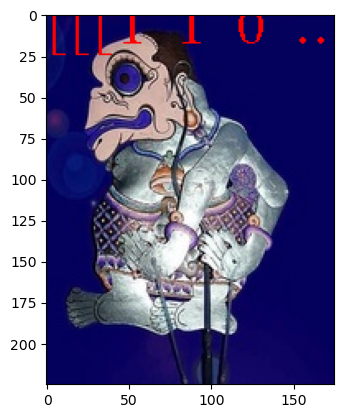

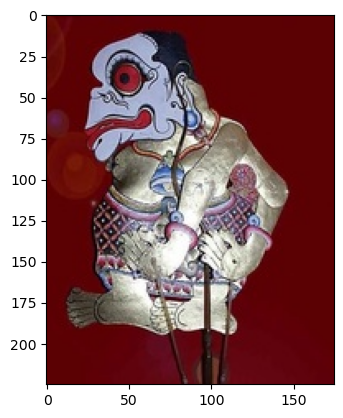

In [71]:
letter, image = get_letters('/kaggle/input/wayang-bagong-cepot-gareng-petruk-semar/images/test/wayang_bagong_(1).jpg')
word = get_word(letter)
print('predicted: ' + word)
plt.figure()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

1/1 [==============================] - 0s 40ms/step
predicted: [[[1 1 0 ... 1 1 0]
  [0 1 1 ... 0 1 1]]]


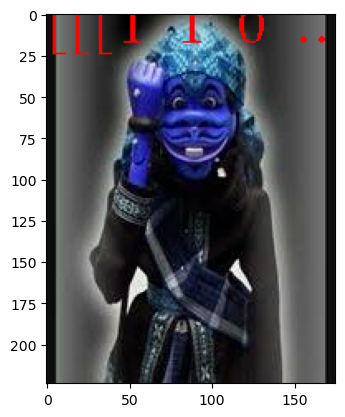

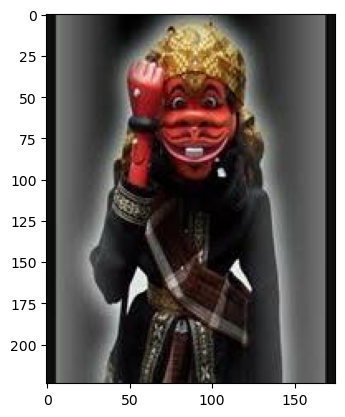

In [72]:
letter, image = get_letters('/kaggle/input/wayang-bagong-cepot-gareng-petruk-semar/images/test/wayang_cepot_275.jpg')
word = get_word(letter)
print('predicted: ' + word)
plt.figure()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

1/1 [==============================] - 0s 39ms/step
predicted: [[[1 1 0 ... 1 1 0]
  [0 1 1 ... 0 1 1]]]


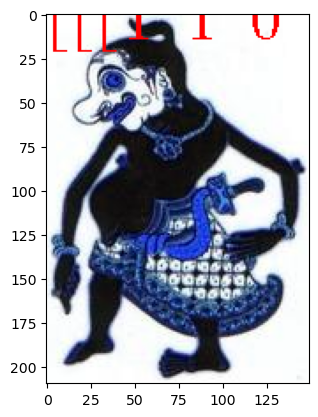

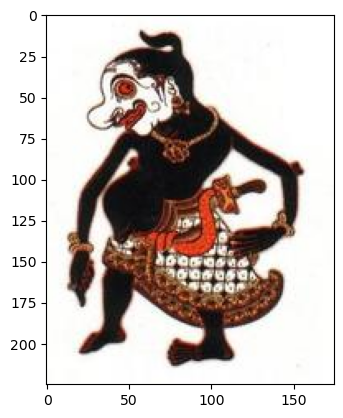

In [79]:
letter, image = get_letters('/kaggle/input/wayang-bagong-cepot-gareng-petruk-semar/images/test/wayang_gareng_71.jpg')
word = get_word(letter)
print('predicted: ' + word)
plt.figure()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

1/1 [==============================] - 0s 42ms/step
predicted: [[[1 1 0 ... 1 1 0]
  [0 1 1 ... 0 1 1]]]


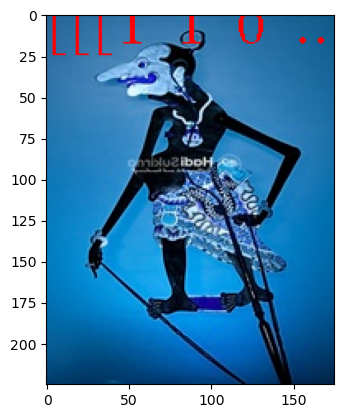

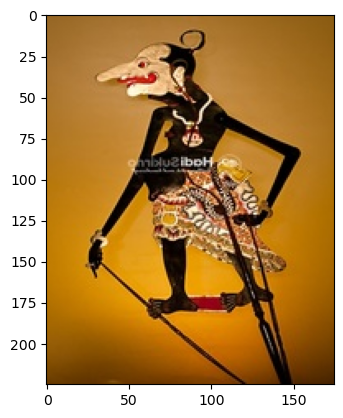

In [81]:
letter, image = get_letters('/kaggle/input/wayang-bagong-cepot-gareng-petruk-semar/images/test/wayang_petruk_265.jpg')
word = get_word(letter)
print('predicted: ' + word)
plt.figure()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

1/1 [==============================] - 0s 40ms/step
predicted: [[[1 1 0 ... 1 1 0]
  [0 1 1 ... 0 1 1]]]


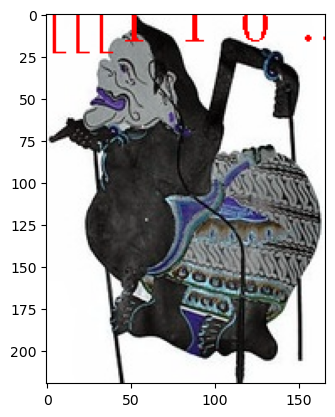

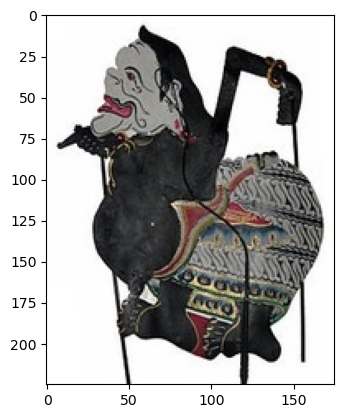

In [82]:
letter, image = get_letters('/kaggle/input/wayang-bagong-cepot-gareng-petruk-semar/images/test/wayang_semar_9.jpg')
word = get_word(letter)
print('predicted: ' + word)
plt.figure()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))